In [41]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [42]:
train_df = pd.read_csv('/kaggle/input/titanic/train.csv')
test_df = pd.read_csv('/kaggle/input/titanic/test.csv')

In [43]:
train_len = len(train_df)
# combine two dataframes
df = pd.concat([train_df, test_df], axis=0)
df = df.reset_index(drop=True)

In [44]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [45]:
df.describe()
# As we see here only 'Age' column has missing values

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,1309.000000,891.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000
mean,655.000000,0.383838,2.294882,29.881138,0.498854,0.385027,33.295479
std,378.020061,0.486592,0.837836,14.413493,1.041658,0.865560,51.758668
min,1.000000,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,328.000000,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,655.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,982.000000,1.000000,3.000000,39.000000,1.000000,0.000000,31.275000
max,1309.000000,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200


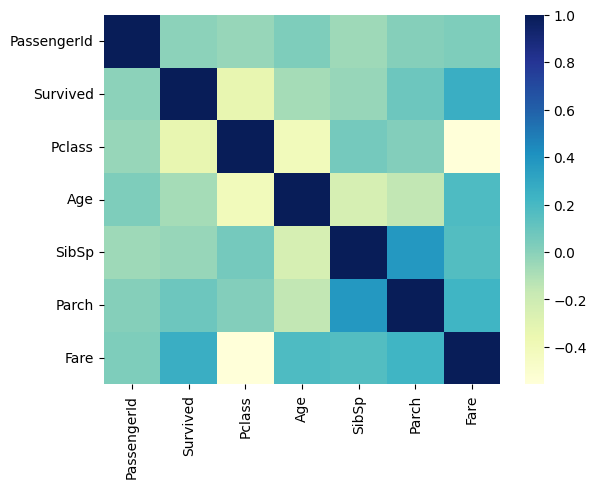

In [46]:
num_cols = df.select_dtypes(include=['int', 'float'])
sns.heatmap(num_cols.corr(), cmap='YlGnBu')
plt.show()
# We can see that passengerId is not correlated to survived column. 
# Age (negatively) and SibSp is also slightly correlated

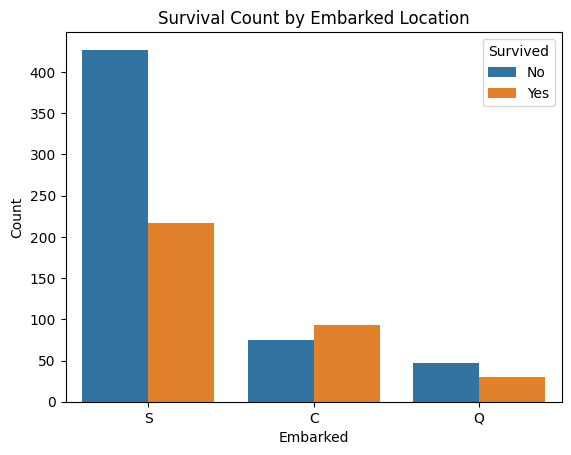

In [47]:
# Does the embarkation make any difference (or should I drop it)? 
sns.countplot(data=df, x='Embarked', hue='Survived')

plt.xlabel('Embarked')
plt.ylabel('Count')
plt.title('Survival Count by Embarked Location')
plt.legend(title='Survived', labels=['No', 'Yes'])

plt.show()

In [48]:
df.isna().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

In [49]:
#impute missing values in 'Age' column
most_frequent_age = df['Age'].mode()[0]
df['Age'].fillna(most_frequent_age, inplace = True)

/tmp/ipykernel_33/1411034469.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Age'].fillna(most_frequent_age, inplace = True)


In [50]:
# More than 75% of Cabin column is missing. So I want to analyze whether should I drop Cabin column
def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

# Usage
cabin_survived_cross = pd.crosstab(df['Cabin'], df['Survived'])
cramer_v = cramers_v(cabin_survived_cross.values)
print("Cramer's V for Cabin:", cramer_v)

cabin_survived_cross = pd.crosstab(df['Pclass'], df['Survived'])
cramer_v = cramers_v(cabin_survived_cross.values)
print("Cramer's V for Pclass:", cramer_v)

cabin_survived_cross = pd.crosstab(df['SibSp'], df['Survived'])
cramer_v = cramers_v(cabin_survived_cross.values)
print("Cramer's V for SibSp:", cramer_v)

cabin_survived_cross = pd.crosstab(df['Parch'], df['Survived'])
cramer_v = cramers_v(cabin_survived_cross.values)
print("Cramer's V for Parch:", cramer_v)

cabin_survived_cross = pd.crosstab(df['Age'], df['Survived'])
cramer_v = cramers_v(cabin_survived_cross.values)
print("Cramer's V for Age:", cramer_v)

cabin_survived_cross = pd.crosstab(df['Embarked'], df['Survived'])
cramer_v = cramers_v(cabin_survived_cross.values)
print("Cramer's V for Embarked:", cramer_v)

cabin_survived_cross = pd.crosstab(df['Sex'], df['Survived'])
cramer_v = cramers_v(cabin_survived_cross.values)
print("Cramer's V for Sex:", cramer_v)

# Cramer's V for Cabin is 0.267548, It's relatively High to other variables, So I am keeping this column

NameError: name 'chi2_contingency' is not defined

In [51]:
# Impute missing values in Cabin column with the preceding non-null value
df['Cabin'] = df['Cabin'].ffill()
df['Cabin'] = df['Cabin'].bfill()

In [52]:
# Impute missing values in Embarked column with the preceding non-null value
df['Embarked'] = df['Embarked'].ffill()
df['Embarked'] = df['Embarked'].bfill()

In [53]:
# Impute missing values in Fare column with the preceding non-null value
df['Fare']=df['Fare'].fillna(df['Fare'].median())

In [54]:
df.isna().sum() #there are no missing values left

PassengerId      0
Survived       418
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin            0
Embarked         0
dtype: int64

In [55]:
# distribution of numeric values
df.select_dtypes(exclude=['object']).columns

Index(['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare'], dtype='object')

/tmp/ipykernel_33/3255828239.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['Age'])
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Age', ylabel='Density'>

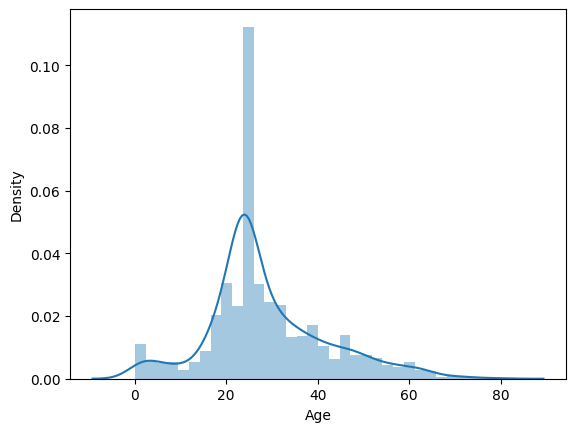

In [56]:
sns.distplot(df['Age'])

/tmp/ipykernel_33/1634579339.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['SibSp'])
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='SibSp', ylabel='Density'>

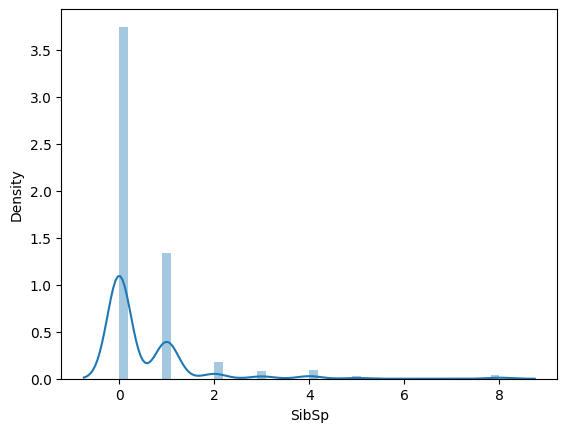

In [57]:
sns.distplot(df['SibSp'])

/tmp/ipykernel_33/63704092.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['Parch'])
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Parch', ylabel='Density'>

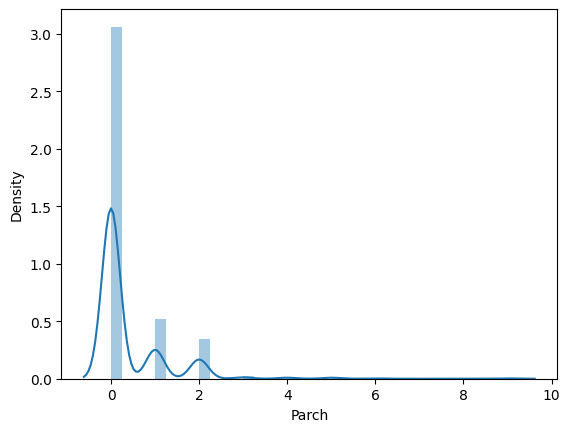

In [58]:
sns.distplot(df['Parch'])

/tmp/ipykernel_33/3425841524.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['Fare'])
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Fare', ylabel='Density'>

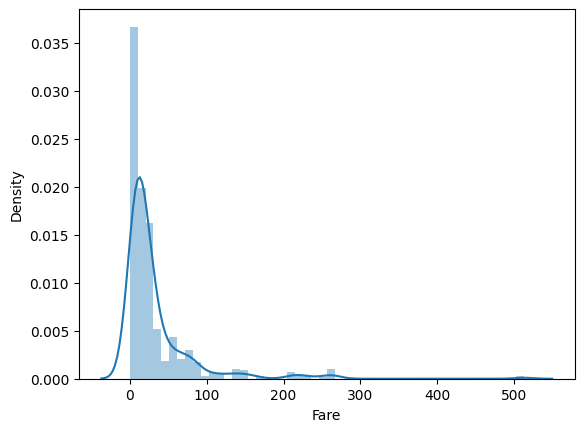

In [59]:
sns.distplot(df['Fare'])

In [60]:
df['Fare'] = np.log(df['Fare']+1)

/tmp/ipykernel_33/3425841524.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['Fare'])
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Fare', ylabel='Density'>

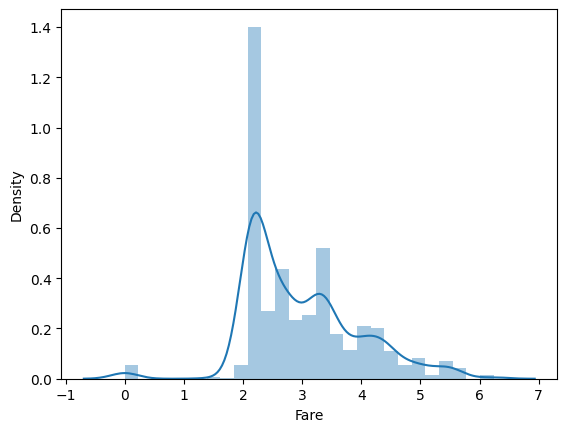

In [61]:
sns.distplot(df['Fare'])

In [62]:
ohe_cols = ['Ticket', 'Cabin', 'Embarked']
lbe_cols = ['Sex']

num_cols = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

cols_to_drop = ['PassengerId', 'Survived', 'Name']

In [63]:
# Missing values count in 'Sex' column
df['Sex'].isna().sum()
# Since there are no missing values, we can freely use label Encoding without processing data beforehand

0

In [64]:
# Making custom encoder for using label encoding in pipeline
class CustomLabelEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.label_encoders = {}

    def fit(self, X, y=None):
        # Convert X to DataFrame if it's not already
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
        for col in X.columns:
            self.label_encoders[col] = LabelEncoder()
            self.label_encoders[col].fit(X[col])
        return self

    def transform(self, X):
        # Convert X to DataFrame if it's not already
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
        X_copy = X.copy()
        for col, encoder in self.label_encoders.items():
            X_copy[col] = encoder.transform(X[col])
        return X_copy

In [65]:
# Pipelines for scaling and encoding data
num_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler())
])

lbe_pipeline = Pipeline(steps=[
    ('lbe', CustomLabelEncoder())
])

ohe_pipeline = Pipeline(steps=[
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

In [66]:
col_trans = ColumnTransformer(transformers=[
    ('num_p', num_pipeline, num_cols),
    ('lbe_p', lbe_pipeline, lbe_cols),
    ('ohe_p', ohe_pipeline, ohe_cols),
    ],
    remainder='passthrough', 
    n_jobs=-1)

In [67]:
train_df = df.iloc[:train_len, :]
test_df = df.iloc[train_len:, :]

In [68]:
X = train_df.drop(cols_to_drop, axis=1)
y = train_df['Survived']

X_test = test_df.drop(cols_to_drop, axis=1)

In [70]:
X_preprocessed = col_trans.fit_transform(X)
X_preprocessed_test = col_trans.transform(X_test)

In [71]:
# Calculate results
def Calculate(model):
    train_X, test_X, train_y, test_y = train_test_split(X_preprocessed, y, test_size=0.25, random_state=0)
    model.fit(train_X, train_y)
    print('Accuracy: ', model.score(test_X, test_y))
    
    score = cross_val_score(model, X_preprocessed, y, cv=5)
    print('CV score: ', np.mean(score))

In [72]:
model = LogisticRegression()
Calculate(model)

Accuracy:  0.8295964125560538
CV score:  0.8047078023978408


In [73]:
model = DecisionTreeClassifier()
Calculate(model)

Accuracy:  0.8385650224215246
CV score:  0.8238277572029377


In [74]:
model = RandomForestClassifier()
Calculate(model)

Accuracy:  0.8295964125560538
CV score:  0.8350323269097985


In [75]:
model = XGBClassifier()
Calculate(model)

Accuracy:  0.8609865470852018
CV score:  0.8283033080158182


In [83]:
# Test Submission
model = LogisticRegression()
model.fit(X_preprocessed, y)
pred_test = model.predict(X_preprocessed_test)

submission_df = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Survived': pred_test
})

submission_df.to_csv('submission_logictic.csv', index = False)

In [80]:
submission_df

,PassengerId,Survived
891,892,0.0
892,893,0.0
893,894,0.0
894,895,0.0
895,896,1.0
...,...,...
1304,1305,0.0
1305,1306,1.0
1306,1307,0.0
1307,1308,0.0
